# Visão Computacional com Aprendizado Profundo

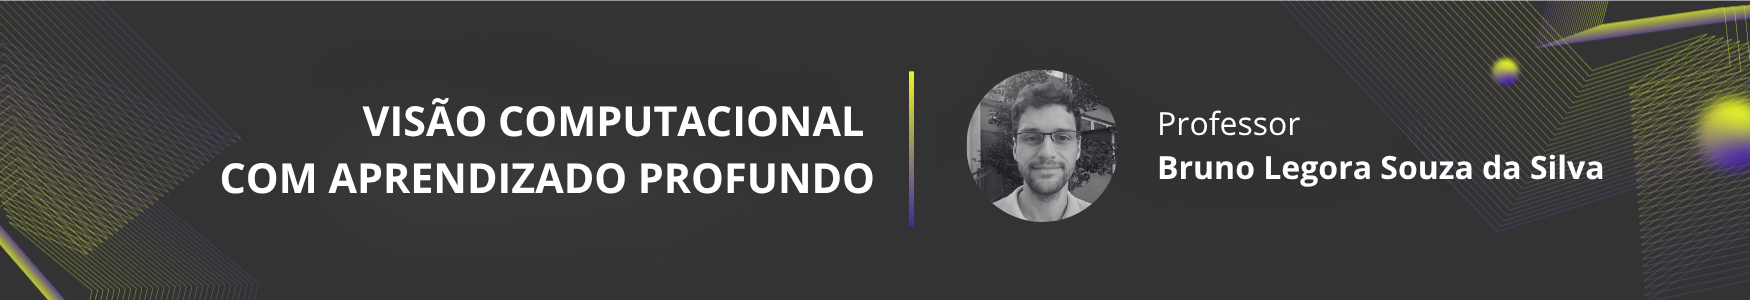

# Laboratório 4 - Pipeline clássico de visão computacional (detecção de caracteres)

Neste laboratório, vamos ver um pipeline clássico (e bastante simplificado) de uma tarefa de visão computacional - localização de caracteres em imagens.

Como descritores, iremos usar um conjunto de características obtidos através de "blobs" (regiões conectadas - com intensidade de pixel similar - extraídas da imagem) detectados por uma técnica chamada Maximally stable extremal regions (MSER).

Como exemplo de "blobs", temos as regiões pretas dos caracteres de uma placa de trânsito, a faixa azul, as letras BR na cor preta e BRASIL na cor branca, a região verde da bandeira, entre outras:

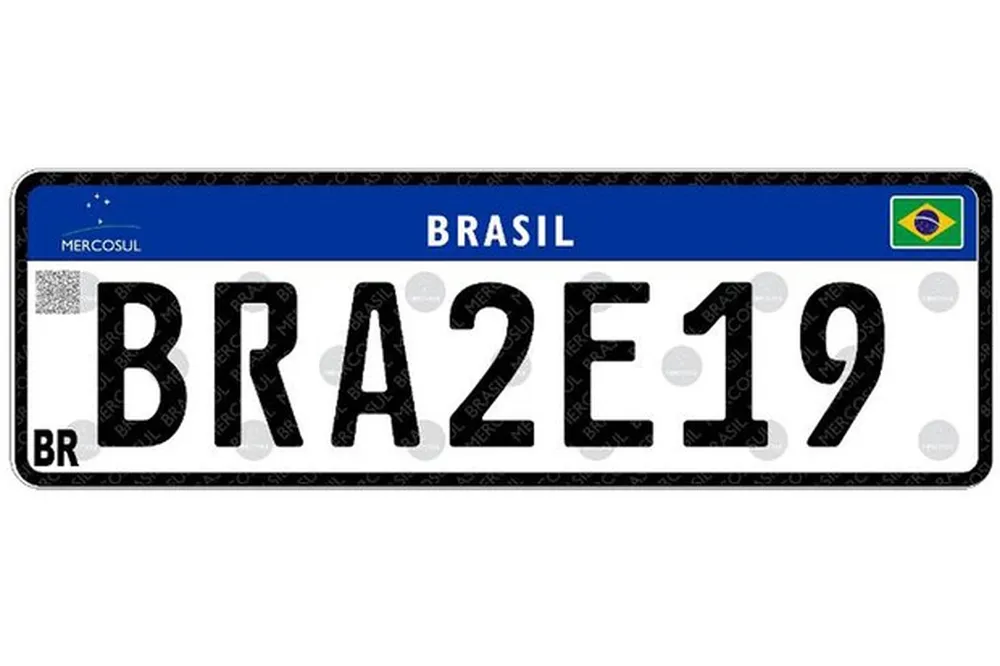

A técnica [MSER](https://en.wikipedia.org/wiki/Maximally_stable_extremal_regions) pode ser explicada, de maneira muito simplificada, da seguinte forma:

- Varios limiares são aplicados a uma imagem em tons de cinza (ou a canais de cores separadamente). Em cada "iteração", um limiar é definido e aplicado à imagem, cujos pixels maiores ou iguais a esse limiar assumirão valor 255 e os menores assumirão valor 0 (para imagens de 8 bits). Um exemplo pode ser visto abaixo.
- Os limiares distintos são aplicados na imagem e os "blobs" (regiões conectadas pretas ou brancas) cujo tamanho se mantém ao longo de diferentes limiares são detectadas pelo algoritmo MSER.
- Para mais informações sobre a técnica, você pode consultar o link acima.

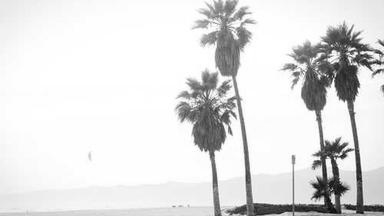

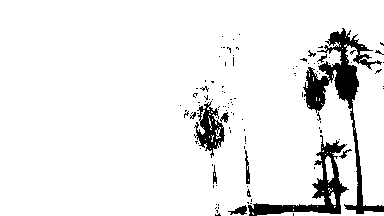

In [ ]:
!wget https://picsum.photos/384/216 -O image.jpg -q

import cv2

img = cv2.imread('image.jpg')

from google.colab.patches import cv2_imshow

img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cv2_imshow(img)
cv2_imshow(255*(img > 100))

O processo aqui será o seguinte:

- Carregaremos uma base de dados de imagens com letras. Essa base de dados possui uma grande variabilidade, então trabalharemos apenas com duas imagens para facilitar o nosso aprendizado.
- Para carregar a base de dados ICDAR 2013, iremos usar o módulo deeplake (versão 3.9 - não pode ser 4.0 ou superior para esse teste)
- Instalando o módulo:

In [ ]:
!pip install deeplake==3.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.6/589.6 kB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.3 MB/s eta 0:00:

Após instalar o pacote, importamos ele e baixamos a base de dados.

Obs: Há duas bases de dados abaixo. A "text localize" deveria ser usada, mas ela não nos dá a posição exata de cada um dos caracteres, apenas das palavras como um todo. Para nosso exemplo, queremos trabalhar com os caracteres, então vamos extrair essa informação da base "segmentation"

In [ ]:
import deeplake
# ds = deeplake.load("hub://activeloop/icdar-2013-text-localize-train")
ds = deeplake.load("hub://activeloop/icdar-2013-segmentation-train")

/usr/local/lib/python3.11/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.11) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
-

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/icdar-2013-segmentation-train



-

hub://activeloop/icdar-2013-segmentation-train loaded successfully.



A base possui algumas informações. As duas principais que usaremos aqui são:

"Images" - As imagens da base de dados. São 229 no total (para essa base)
"boxes/box" - os "quadrados" delimitadores dos caracteres.

In [ ]:
import numpy as np
images = ds["images"].numpy(aslist=True)
boxes = ds["boxes/box"].numpy(aslist=True)

Em seguida, vamos ver uma dessas imagens. O seguinte processo foi feito:

- Conversão de uma imagem para tons de cinza. Não é necessário nesse momento, mas facilita no restante do código
- Uma cópia da imagem é feita para desenhar as caixas delimitadores (bounding boxes) dos caracteres
- As caixas delimitadoras (retângulos) são desenhados na imagem original, da mesma forma que fizemos no laboratório 3.

Logo abaixo, podemos ver que a imagem possui o texto "Footpath to Colchester and Greenstead" - e os 33 caracteres estão com suas caixas delimitadoras desenhadas.

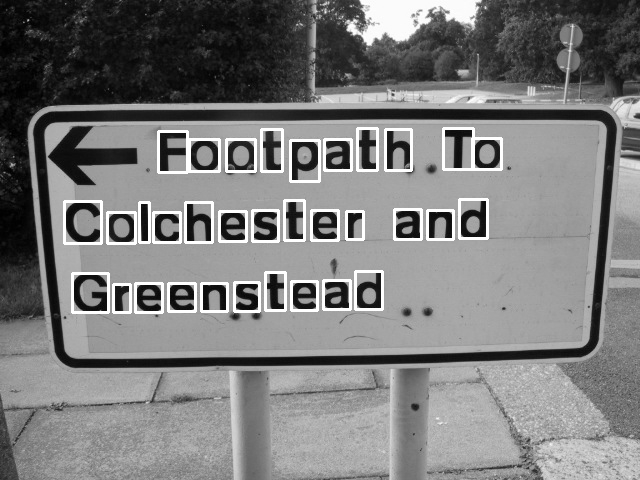

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img = images[0].copy()
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_boxes = img.copy()

for box in boxes[0]:
  # "box" não é carregada como inteiro e a função abaixo reclama
  # Daí, é necessário converter para inteiro.
  box = box.astype(np.uint32)
  cv2.rectangle(img_boxes,(box[0],box[1]),(box[2],box[3]), (255), 2)

cv2_imshow(img_boxes)


A partir daqui, iremos trabalhar em cima da imagem original (sem as caixas delimitadores) para extrair as características dos "blobs" detectados, identificarmos quais se referem a caracteres e quais não, para que usemos eles em um classificador comum (SVM.

O primeiro passo é usar as funções do OpenCV que nos detectam as MSER. Isso é feito nas duas primeiras linhas da célula de código abaixo. Ela retorna um vetor de regiões (coordenadas dos pontos) e das caixas delimitadores (bboxes).

Em seguida, temos um "problema" - as bboxes retornadas seguem o formato [x,y,w,h] - coordenadas x,y do ponto superior esquerdo, largura e altura. O OpenCV (em python, pelo menos) trabalha com os retângulos no formado [x,y,x2,y2], sendo x e y as coordenadas do ponto superior esquerdo e x2 e y2 as coordenadas do ponto inferior direito. Assim, devemos fazer uma pequena conversão, feita dentro do primeiro for da célula abaixo.

Em seguida, vamos criar duas imagens totalmente na cor preta (todos os pixels zerados) para ilustrar duas regiões - uma que não deveria representar um caractere (índice 1) e outra que representa um caractere (índice 150). Abaixo, usamos o conjunto de pontos retornado pela função de detectar MSER para desenhar as regiões na imagem a partir das coordenadas delas.

Finalmente, mostramos as duas imagens. Reparem nos "blobs" - regiões de cor similar (na imagem original) que a técnica MSER detecta. A de índice 1 representa uma folhagem "escondida" atrás de uma placa e a de índice 150 representa um caractere "s".

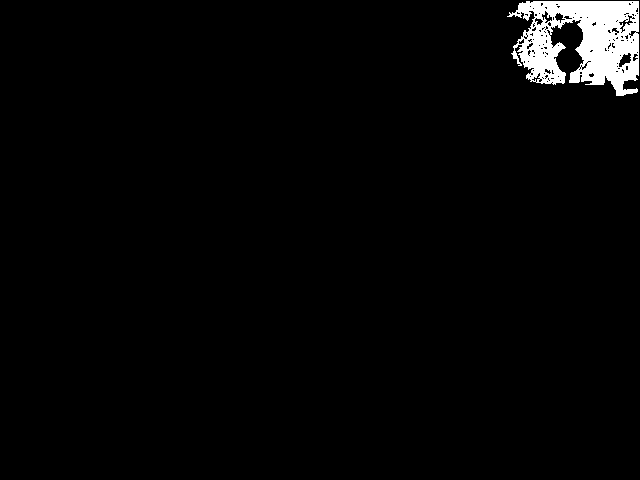

----


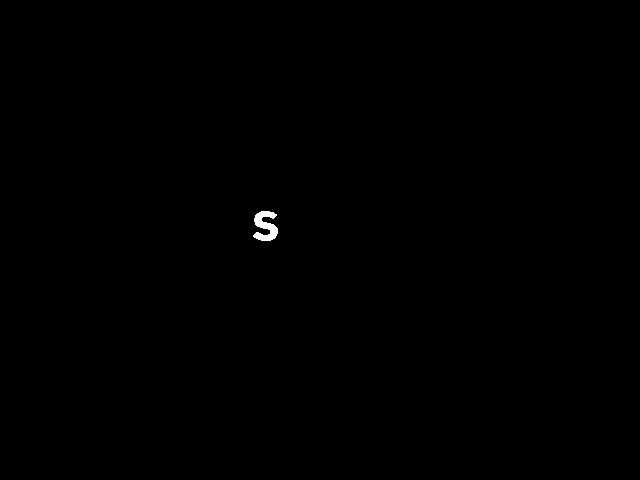

In [ ]:
# Detecção das MSER
mser = cv2.MSER_create()
regions, bboxes_mser = mser.detectRegions(img)

# Conversão das coordenadas das caixas delimitadoras
for i in range(len(bboxes_mser)):
  bboxes_mser[i] = (bboxes_mser[i][0],bboxes_mser[i][1],bboxes_mser[i][2]+bboxes_mser[i][0],bboxes_mser[i][3]+bboxes_mser[i][1])

# Cria imagens "pretas"
mser_image_outro = np.zeros(img.shape,np.uint8)
mser_image_caract = np.zeros(img.shape,np.uint8)

# Joga o valor 255 em todas as coordenadas da MSER de índice 1
for point in regions[1]:
  mser_image_outro[point[1],point[0]] = 255

# Joga o valor 255 em todas as coordenadas da MSER de índice 150
for point in regions[150]:
  mser_image_caract[point[1],point[0]] = 255

# Imprime as duas imagens
cv2_imshow(mser_image_outro)
print("----")
cv2_imshow(mser_image_caract)

Neste ponto do laboratório 4, temos todos os "blobs" detectados da primeira imagem da base de dados. Para tentar classificá-los como caracteres ou não, precisamos de uma estratégia para rotular eles a partir das informações fornecidas pela base de dados.

Aqui, adotaremos a seguinte estratégia:

- Cada região detectada possui uma bounding-box.
- Se essa bounding box estiver dentro das bounding boxes dadas pela base de dados, consideraremos que a região pertence a um caractere.
- Para isso, vemos se a boundingbox da MSER tenha uma interseção de 80% da área (altura x largura) de uma bounding-box da base de dados. Se tiver, consideramos um caractere. Caso contrário, não é um caractere.
- Outro critério de filtro é que a bounding box detectada não pode ter mais de o dobro da área da bbox da base de dados que está sendo comparada.

No exemplo abaixo, temos 2 bounding boxes - uma verde e uma vermelha. A região de interseção das duas é colorida de cinza. A ideia é que a área cinza tenha área similar a região vermelha, por exemplo (considerando que a região vermelha é a caixa delimitadora descrita pela base de dados). No caso 1, a área cinza é muito pequena, então não é considerada um caractere. No 2, a mesma coisa. No 3, a área verde (detecção) é muito maior que a cinza, então é descartado pelo segundo critério descrito acima. No caso 4, não há interseção. No caso 5, a detecção coincide com a área cinza - que é menor que a vermelha. Se a relação das áreas for de 80%, a detecção é considerada um caractere.


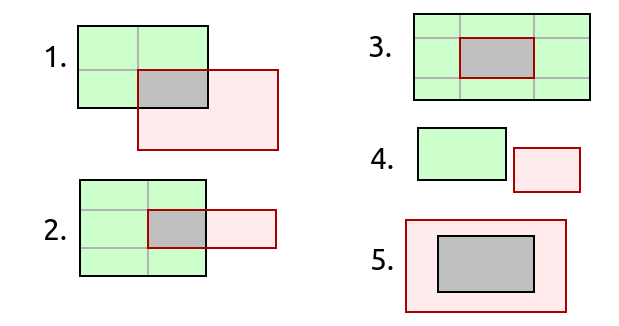

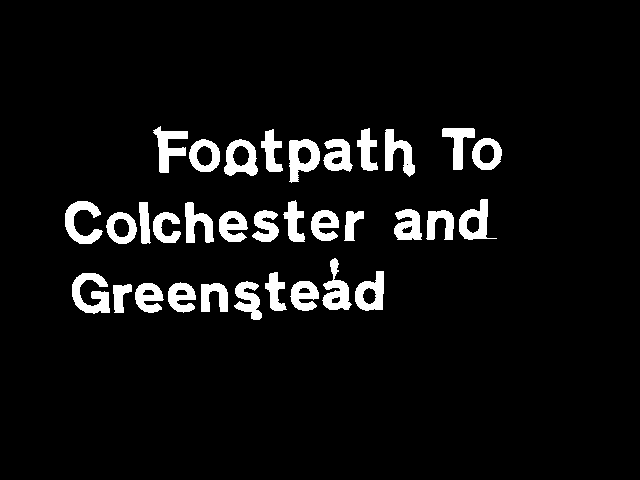

In [ ]:
# Definimos uma função para calcular a interseção de 2 bounding boxes
def intersection(a,b):
  x_left = max(a[0], b[0])
  y_top = max(a[1], b[1])
  x_right = min(a[2], b[2])
  y_bottom = min(a[3], b[3])
  if x_right < x_left or y_bottom < y_top:
    return (0,0,0,0)
  else:
    return (x_left, y_top, x_right, y_bottom)

# Função que calcula a area de um retangulo
def area(rect):
  tl = (rect[0],rect[1])
  br = (rect[2],rect[3])
  return (br[0]-tl[0])*(br[1]-tl[1])

# Cria um vetor de classes
classes_mser = [0]*len(bboxes_mser)

# Criamos uma imagem para mostrar quais regiões foram consideradas caracteres
image_GTs = np.zeros(img.shape,np.uint8)

# Comparamos todas as bounding boxes das detecções bboxes_mser com as bboxes
# fornecidas pela base ICDAR - referentes a imagem 0 (boxes[0])
# Aplicando as regras:
# Se area(intersec) >= 0.8*area(box_base_dados) E
# area(detecção) <= 2*area(box_base_dados), considera a região como um caractere
for i in range(len(bboxes_mser)):
  for box_gt in boxes[0]:
    rect = intersection(bboxes_mser[i],box_gt.astype(np.uint32))
    if area(rect) >= 0.8*area(box_gt) and area(bboxes_mser[i]) <= 2*area(box_gt):
      classes_mser[i] = 1

# Agora, apenas vamos ver quais foram os blobs considerados caracteres:
for i in range(len(classes_mser)):
  if (classes_mser[i] == 1):
    for point in regions[i]:
      image_GTs[point[1],point[0]] = 255

cv2_imshow(image_GTs)

A nossa estratégia, para esta imagem, funcionou! Não foi exato, pois vemos algumas regiões que não fazem exatamente parte da letra, como a região acima do a e abaixo do s de "greenstead", mas fizemos de forma automática sem termos que marcar uma a uma.

Agora temos um conjunto de regiões rotuladas como caracteres ou não. Para tentarmos diferenciá-las, usaremos um classificador SVM simples. Porém, extrairemos características de cada uma das regiões para que o SVM consiga processá-las de forma uniforme.

Para iniciar, vamos considerar as seguintes características:
- Área da região
- perímetro
- área do fecho convexo
- perímetro do fecho convexo
- razão de aspecto (largura/altura)

Fecho convexo é definido como uma região convexa mínima que é capaz de conter todos os pontos de uma região. Como podem ver na imagem abaixo, a região azul é o fecho convexo dos pontos. Para cada caractere, o fecho convexo é diferente. Por exemplo, o fecho convexo de um T deve ser algo próximo de um triângulo, já para um o, o fecho convexo é o próprio caractere, idealmente.

Para cada uma das regiões (caractere ou não), vamos calcular as características acima e construir um vetor de características.



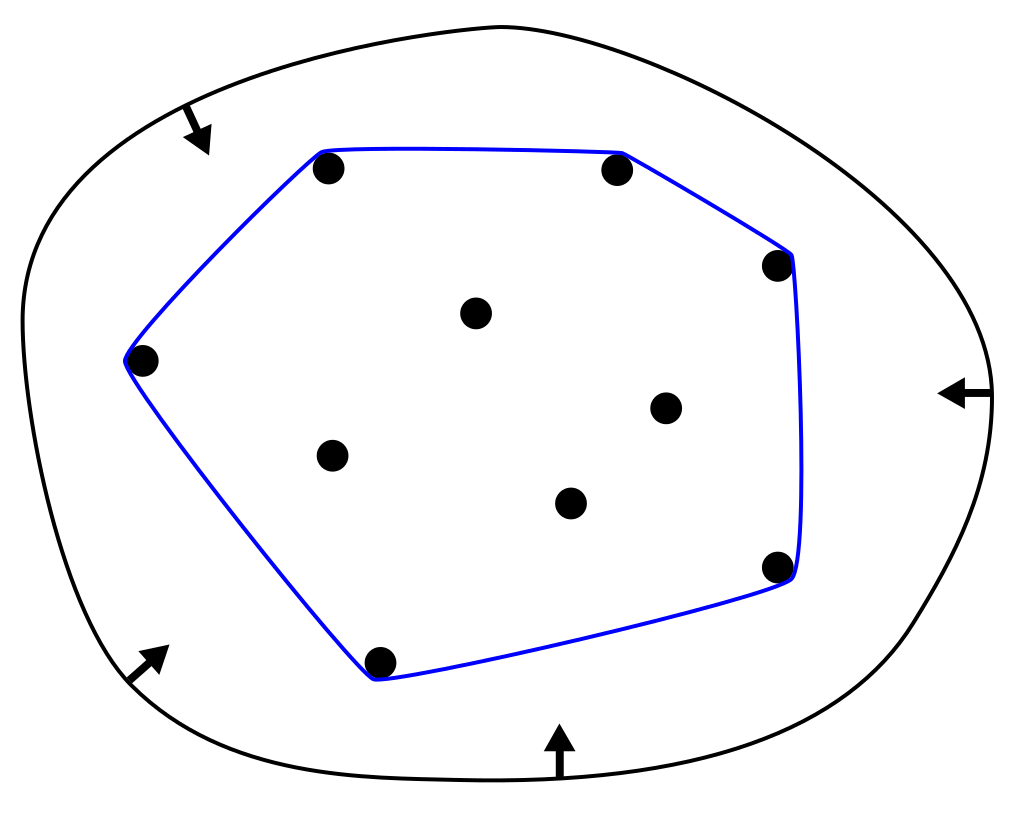

Para calcular tais características, precisamos "converter" cada conjutno de pontos das MSER em uma imagem cortada que representa aquele componente conectado (por ex, a letra S) da imagem de algumas células acima.

Primeiro fazemos uma conversão

In [ ]:
# Construindo o vetor de características:
feat_vec = [0]*len(bboxes_mser) # pré-alocando

for i in range(len(bboxes_mser)):
  # Salvando as coordenadas iniciais da boundind box, e calculando larg/alt
  dx = int(bboxes_mser[i][0])
  dy = int(bboxes_mser[i][1])
  alt = bboxes_mser[i][3]-bboxes_mser[i][1]
  larg = bboxes_mser[i][2]-bboxes_mser[i][0]
  # Criando uma imagem pequena que caiba só o blob.
  image = np.zeros((int(alt),int(larg)),np.uint8)
  # Desenhando o blob na imagem pequena
  for point in regions[i]:
      #Reparem no dy e dx. As coordenadas devem ser deslocadas pois a imagem não
      # está no tamanho original. As coordenadas devem ser relativas ao ponto "inicial"
      # (superior esquerdo) da bbox.
      image[point[1]-dy,point[0]-dx] = 255


  # Em seguida, calculamos as características a partir do contorno delas.
  # É necessário fazer isso pois o openCV fornece funções que calculam
  # características a partir do contorno, e não da MSER. Veremos elas logo abaixo.

  contours,hierarchy = cv2.findContours(image,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)

  # Contornos podem ser explicados simplesmente como uma curva que une todos os
  # pontos contínuos (ao longo da fronteira), com a mesma cor ou intensidade.
  # Os contornos são uma ferramenta útil para análise de formas e detecção e
  # reconhecimento de objetos. (traduzido do site do OpenCV)

  # Definimos as características
  area = 0
  perimetro = 0
  areaFechoConvexo = 0
  perimetroFechoConvexo = 0
  aspectRatio = larg/alt

  # A única característica que podemos calcular por enquanto é o aspectRatio,
  # pois só precisamos da altura e da largura.

  for j in range(len(contours)):
    # Aqui, percorremos os contornos para calcular as features listadas.

    # Em geral, contornos podem ser externos ou internos (buracos)
    # A única restrição é que caso seja um contorno interno (buraco), a área deve
    # ser descontada da área do contorno externo.
    # Buracos são identificados caso a hierarquia seja >= 0.
    if hierarchy[0][j][3] < 0: #contorno externo
      # Calcula a área
      area += cv2.contourArea(contours[j])
      # Calcula o perímetro
      perimeter = cv2.arcLength(contours[j],False)
      # Calcula o fecho convexo
      pontosFechoConvexo = cv2.convexHull(contours[j])
      if len(pontosFechoConvexo) == 0:
        pontosFechoConvexo = contours[j]
      # Se o cálculo falhar por qualuqer motivo, considera que o fecho
      # convexo é o próprio contorno
      # Calcula área do fecho convexo
      areaFechoConvexo = cv2.contourArea(pontosFechoConvexo)
      # Calcula perímetro do fecho convexo
      perimetroFechoConvexo = cv2.arcLength(pontosFechoConvexo,True)
    else: #buraco
      # Caso tenha um buraco, desconte a área dele.
      area -= cv2.contourArea(contours[j])

  # Com as features calculadas, montamos o vetor de características para a região
  # de índice i
  feat_vec[i] = [area,perimetro,areaFechoConvexo,perimetroFechoConvexo,aspectRatio]

# Ao finalizar, convertemos todas as características para uma matriz do numpy
# do tipo float32.
feat_vec = np.asarray(feat_vec,dtype=np.float32)

Neste ponto, já temos:

- Vetor de características das MSER
- Classes

Já podemos, então, usar o nosso classificador. Usaremos um bem simples: SVM, que já foi visto por vocês em outras matérias.

O uso dele é bem simples: importamos a biblioteca, criamos um classificador com o kernel desejado (usaremos rbf nesse experimento), criamos um split de treino e teste e usamos o métoto fit para treinarmos o SVM.

Em seguida, usamos o metodo predict para testarmos o classificador no conjunto de teste.

A acurácia do modelo deu 95%, o que significa que nosso classificador deve ser bom!

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
clf = svm.SVC(kernel='rbf')

# Dividindo os dados entre 80% treino e 20% teste.
X_train, X_test, y_train, y_test = train_test_split(feat_vec, classes_mser, test_size=0.2, random_state=42)
# Treinando o SVM
clf.fit(X_train, y_train)
# Fazendo previsões nos dados de teste
y_pred = clf.predict(X_test)

# Calculando a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo: %.2f" % accuracy)


Acurácia do modelo: 0.95


A partir daqui, iremos testar o nosso método em duas imagens: A própria imagem que usamos para treino (só para uma análise rápida) e com uma imagem nova.

Os códigos abaixo são praticamente cópias dos códigos que já foram feitos, mas sem os comentários que estavam acima.

Primeiramente, vamos ver a imagem que usamos como base para treinar o SVM:

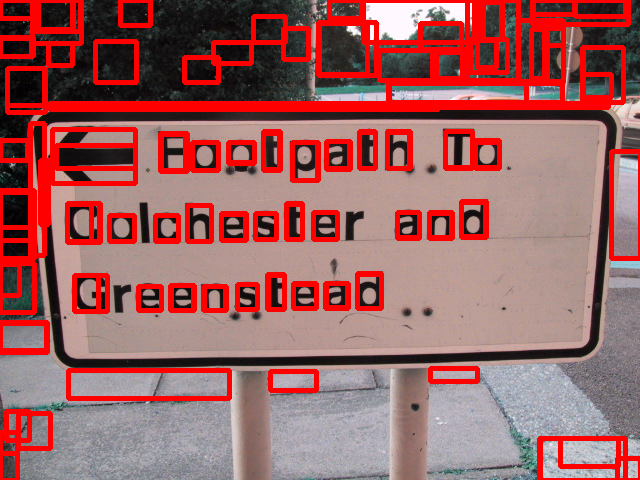

In [ ]:
#Vamos testar o classificador na primeira imagem do conjunto!

img_test = images[0].copy()

regions_test, bboxes_mser_test = mser.detectRegions(img_test)

for i in range(len(bboxes_mser_test)):
  bboxes_mser_test[i] = (bboxes_mser_test[i][0],bboxes_mser_test[i][1],bboxes_mser_test[i][2]+bboxes_mser_test[i][0],bboxes_mser_test[i][3]+bboxes_mser_test[i][1])

feat_vec_test = [0]*len(bboxes_mser_test)

for i in range(len(bboxes_mser_test)):
  dx = int(bboxes_mser_test[i][0])
  dy = int(bboxes_mser_test[i][1])
  alt = bboxes_mser_test[i][3]-bboxes_mser_test[i][1]
  larg = bboxes_mser_test[i][2]-bboxes_mser_test[i][0]
  image = np.zeros((int(alt),int(larg)),np.uint8)
  for point in regions_test[i]:
      image[point[1]-dy,point[0]-dx] = 255
  contours,hierarchy = cv2.findContours(image,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
  area = 0
  perimetro = 0
  areaFechoConvexo = 0
  perimetroFechoConvexo = 0
  aspectRatio = larg/alt

  for j in range(len(contours)):
    if hierarchy[0][j][3] < 0: #contour
      area += cv2.contourArea(contours[j])
      perimeter = cv2.arcLength(contours[j],False)
      pontosFechoConvexo = cv2.convexHull(contours[j])
      if len(pontosFechoConvexo) == 0:
        pontosFechoConvexo = contours[j]
      areaFechoConvexo = cv2.contourArea(pontosFechoConvexo)
      perimetroFechoConvexo = cv2.arcLength(pontosFechoConvexo,True)
    else: #hole
      area -= cv2.contourArea(contours[j])

  feat_vec_test[i] = [area,perimetro,areaFechoConvexo,perimetroFechoConvexo,aspectRatio]

feat_vec_test = np.asarray(feat_vec_test,dtype=np.float32)

classes_img2 = clf.predict(feat_vec_test)

for i in range(len(bboxes_mser_test)):
  if classes_img2[i] == 1:
    tl = (bboxes_mser_test[i][0],bboxes_mser_test[i][1])
    br = (bboxes_mser_test[i][2],bboxes_mser_test[i][3])
    cv2.rectangle(img_test,tl,br,(0,0,255),3)

cv2_imshow(img_test)

No exemplo acima, podemos ver que o nosso classificador não foi tão bom quanto imaginávamos... Muitas regiões que não são caracteres foram detectadas como caracteres, e alguns caracteres não foram detectados (3 dos 33).

Isso era, de certa forma, esperado. Foram poucas amostras de caracteres (33 caracteres!), e o nosso conjunto de features foi bem básico.

E, devido ao não balanceamento das classes no treinamento (não nos preocupamos com isso, mas são muito mais amostras negativas que positivas), a acurácia indica um valor alto que não necessariamente mostra que o classificador é bom.

Diversas outras estratégias


Copiando o código, mas agora usando a segunda imagem da base de dados como exemplo:

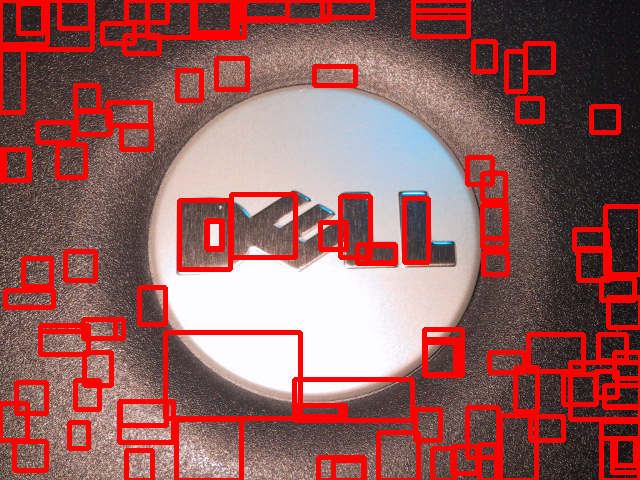

In [ ]:
#Vamos testar o classificador na segunda imagem do conjunto!


img_test = images[1].copy()

regions_test, bboxes_mser_test = mser.detectRegions(img_test)

for i in range(len(bboxes_mser_test)):
  bboxes_mser_test[i] = (bboxes_mser_test[i][0],bboxes_mser_test[i][1],bboxes_mser_test[i][2]+bboxes_mser_test[i][0],bboxes_mser_test[i][3]+bboxes_mser_test[i][1])


feat_vec_test = [0]*len(bboxes_mser_test)

for i in range(len(bboxes_mser_test)):
  dx = int(bboxes_mser_test[i][0])
  dy = int(bboxes_mser_test[i][1])
  alt = bboxes_mser_test[i][3]-bboxes_mser_test[i][1]
  larg = bboxes_mser_test[i][2]-bboxes_mser_test[i][0]
  image = np.zeros((int(alt),int(larg)),np.uint8)
  for point in regions_test[i]:
      image[point[1]-dy,point[0]-dx] = 255
  contours,hierarchy = cv2.findContours(image,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
  area = 0
  perimetro = 0
  areaFechoConvexo = 0
  perimetroFechoConvexo = 0
  aspectRatio = larg/alt


  for j in range(len(contours)):
    if hierarchy[0][j][3] < 0: #contour
      area += cv2.contourArea(contours[j])
      perimeter = cv2.arcLength(contours[j],False)
      pontosFechoConvexo = cv2.convexHull(contours[j])
      if len(pontosFechoConvexo) == 0:
        pontosFechoConvexo = contours[j]
      areaFechoConvexo = cv2.contourArea(pontosFechoConvexo)
      perimetroFechoConvexo = cv2.arcLength(pontosFechoConvexo,True)
    else: #hole
      area -= cv2.contourArea(contours[j])

  feat_vec_test[i] = [area,perimetro,areaFechoConvexo,perimetroFechoConvexo,aspectRatio]

feat_vec_test = np.asarray(feat_vec_test,dtype=np.float32)

classes_img2 = clf.predict(feat_vec_test)

for i in range(len(bboxes_mser_test)):
  if classes_img2[i] == 1:
    tl = (bboxes_mser_test[i][0],bboxes_mser_test[i][1])
    br = (bboxes_mser_test[i][2],bboxes_mser_test[i][3])
    cv2.rectangle(img_test,tl,br,(0,0,255),3)

cv2_imshow(img_test)

O resultado foi similar! Vários elementos que não são caracteres foram identificados como caracteres.

De certa forma, o desempenho dessas estratégias clássicas dependem de vários fatores, muitos dos quais dependem fortemente de escolhas humanas -  o resultado muda muito variando as próprias features ou classificadores. Com aprendizado profundo, nós veremos que esse procedimento fica "mais fácil" e os resultados ficam melhores - ao custo de mais tempo de processamento no treinamento das redes neurais.

Porém, isso é assunto para as próximas aulas!

Façam o Exercício Avaliativo nº 02, disponível no Ava/Moodle da disciplina!
